# Stats Workflow

**Cara Piske, Graduate Program of Hydrologic Sciences, 2022; Advisor: Dr. Adrian Harpold**<br>
This code processes lidar-derived rasters to evaluate the difference between snow properties (SWE) in under vs. open canopy classifications. <br>
Lidar data were provided by the Airborne Snow Observatory (ASO), the National Center for Airborne Laser Mapping (NCALM), and Watershed Sciences Inc. (WSI). <br>

See: Varhola, A., Coops, N. C., Weiler, M., & Moore, R. D. (2010). Forest canopy effects on snow accumulation and ablation: An integrative review of empirical results. In Journal of Hydrology (Vol. 392, Issues 3–4, pp. 219–233). Elsevier. https://doi.org/10.1016/j.jhydrol.2010.08.009 <br>
and<br>
Kostadinov, T. S., Schumer, R., Hausner, M., Bormann, K. J., Gaffney, R., McGwire, K., Painter, T. H., Tyler, S., & Harpold, A. A. (2019). Watershed-scale mapping of fractional snow cover under conifer forest canopy using lidar. Remote Sensing of Environment, 222, 34–49. https://doi.org/10.1016/j.rse.2018.11.037

In [1]:

# import necessary packages 
from osgeo import gdal, ogr, osr
import csv
import os
import subprocess
import sys
import pdal
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import time
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import subprocess
import statsmodels.api as sm

# competing paths on our PC 
gdal_merge = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_merge.py')
gdal_calc = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_calc.py')
gdal_warp = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_warp.py')
gdal_polygonize = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_polygonize.py')
gdal_proximity = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_proximity.py')

In [2]:
#make sure we're in the right working directory
os.chdir('/')
print(os.getcwd())

G:\


## Load Data

In [3]:
# input - path = str. i.e. 'SCB/kane_veg_metrics/departure/14_withholes/departure_wh_clip2dem.tif'
# input - nd_value = int. no data value
# output - raster_arr = 1D array of raster values (maintaining columns)
def raster_to_array(path, nd_value):
    raster = gdal.Open(path) # open the file 
    raster_arr = raster.GetRasterBand(1).ReadAsArray() #read the first raster band (in this case we know we are only working with single bands) and read to a 2D array
    if raster_arr.dtype == 'int32':
        raster_arr = raster_arr.astype(float)
    raster_arr[raster_arr == nd_value] = np.nan # where the raster is equal to the provided no data value, set values to Nan
    raster_arr_flat = raster_arr.flatten() # flatten the array (row-wise)
    raster = None
    return raster_arr_flat

# Vegetation and Terrain

### Load Data- Create DataFrame

In [217]:
# terrain variables
DEM_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_BE_30m.tif', -9999)
#slope_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_slope_30m.tif', -9999)
nness_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_nness_30m.tif', -9999)

In [218]:
# vegetation variables
fVEG_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/veg_strata/veg_characteristics/NCALM_SCB_2014_fVEG_30m.tif', -9999)
DNC_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/veg_strata/veg_characteristics/NCALM_SCB_2014_DNC_30m.tif', -9999)
clump_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/veg_strata/veg_characteristics/NCALM_SCB_2014_clumpSize_30m.tif', -9999)

#### Define bins

In [137]:
terain_veg_dict = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "slope": slope_arr,
    "fVeg": fVEG_arr,
    "DNC": DNC_arr,
    'clump':clump_arr
})
elev_bins_set = ([1800,2000,2100,2200,2300,2400,2800])
nness_bins_set = ([-0.6,-0.3,0,0.3,0.6])
fVEG_bins_set = ([0,0.2,0.4,0.6,0.8,1.0]) # ([0,0.25,0.5, 0.75, 1.0])
DNC_bins_set = ([0,5,10,15,20])
clump_bins_set = ([0, 0.5, 1, 1.5, 2])

In [7]:
terain_veg_dict['nness_bins'] = pd.cut(terain_veg_dict['nness'], bins=nness_bins_set, right = False,include_lowest= True)
terain_veg_dict['elev_bins'] = pd.cut(terain_veg_dict['elev'], bins=elev_bins_set, right = False,include_lowest= True)
terain_veg_dict['fVeg_bins'] = pd.cut(terain_veg_dict['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
terain_veg_dict['DNC_bins'] = pd.cut(terain_veg_dict['DNC'], bins=DNC_bins_set, right = False,include_lowest= True)
terain_veg_dict['clump_bins'] = pd.cut(terain_veg_dict['clump'], bins=clump_bins_set, right = False,include_lowest= True)

#### Plot

In [ ]:
fVEG_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis
# we want a scatterplot
# specify figure axis (ax=axes)
# data = dataframe name, x = dataframe column name, y = dataframe column name
# hue = color values by variable, marker = specify style, s = size of marker, palette = color palette

sns.boxplot(ax=axes, data=snow_veg_terrain_df, x='elev_bins', y="NCALM_2014_northness", hue = 'coreGap_bins',showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes.set_title('Elevation vs. Northness', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('Northness', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

fVEG_box.savefig('SCB/stats/figures/nness_elev_GapSize.png',transparent=True,bbox_inches='tight')

**Elevation, Nness, Slope**

Text(0.5, 0, 'Northness')

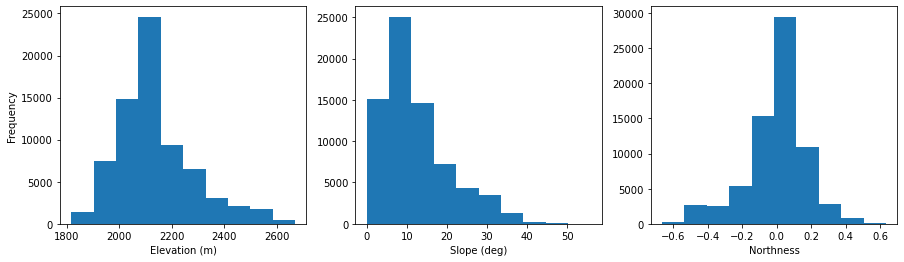

In [89]:
# plot elevation vs. snow depth and fsca (mean)
terrain_hist, axs = plt.subplots(1, 3, figsize =(15,4));
axs[0].hist(terain_veg_dict['elev']); axs[0].set_xlabel('Elevation (m)'); axs[0].set_ylabel('Frequency')
axs[1].hist(terain_veg_dict['slope']); axs[1].set_xlabel('Slope (deg)')
axs[2].hist(terain_veg_dict['nness']); axs[2].set_xlabel('Northness')
#terrain_hist.savefig('lidar_processing/python_scripts/snow_departure_project/figures/terrain_variable_histogram.png')

In [45]:
terain_veg_dict.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'clump', 'nness_bins',
       'elev_bins', 'fVeg_bins'],
      dtype='object')

In [38]:
np.nanmean(terain_veg_dict.fVeg)

inf

Text(0.5, 0, 'Clump Size')

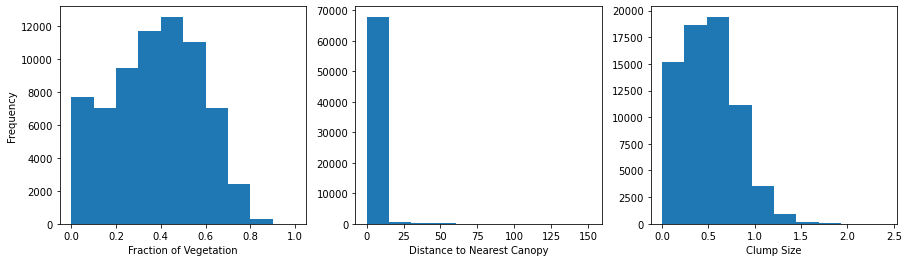

In [50]:
# plot elevation vs. snow depth and fsca (mean)
veg_hist, axs = plt.subplots(1, 3, figsize =(15,4));
axs[0].hist(terain_veg_dict['fVeg']); axs[0].set_xlabel('Fraction of Vegetation'); axs[0].set_ylabel('Frequency')
axs[1].hist(terain_veg_dict['DNC']); axs[1].set_xlabel('Distance to Nearest Canopy')
axs[2].hist(terain_veg_dict['clump']); axs[2].set_xlabel('Clump Size')
#terrain_hist.savefig('lidar_processing/python_scripts/snow_departure_project/figures/terrain_variable_histogram.png')

In [ ]:
elev nness fveg

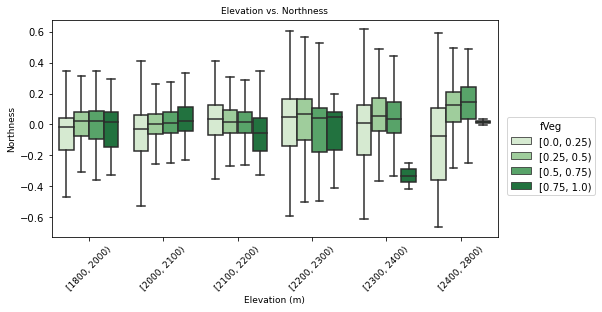

In [34]:
elev_nness_fveg_fig, axes = plt.subplots(1,1,figsize=(8, 4), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=terain_veg_dict, x='elev_bins', y="nness", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes.set_title('Elevation vs. Northness', fontsize = 9); axes.set_xlabel('Elevation (m)', fontsize = 9); axes.set_ylabel('Northness', fontsize = 9)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 9)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'fVeg')
#elev_nness_slope_fig.savefig('AGU/box_figs/terrain_veg/nness_elev_GapSize.png',transparent=True,bbox_inches='tight')

terrain vs fveg

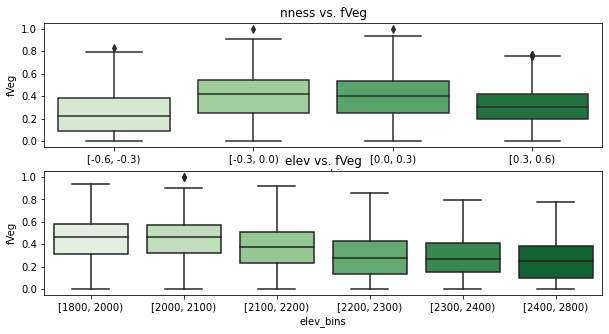

In [99]:
nness_fveg_box, axes = plt.subplots(2,1,figsize=(10, 5), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=terain_veg_dict, x='nness_bins', y="fVeg", palette = 'Greens') #, hue = 'nness_bins'
axes[0].set_title('nness vs. fVeg'); #axes.set(xlabel = 'Vegetation Departure',ylabel = 'Northness'); axes.set_xticklabels(axes.get_xticklabels(),rotation = 45);
#dep_nness_box.savefig('lidar_processing/python_scripts/snow_departure_project/figures/dep_nness_box.png')
sns.boxplot(ax=axes[1], data=terain_veg_dict, x='elev_bins', y="fVeg", palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('elev vs. fVeg');

# Delta Change in Snowpack Properties
We'll start off using only our best estimate of snowpack accumulation, which is the earliest flight available from each year. <br>

## Accumulation
Calculated as the difference between open and tall snowpack

### Load Data - Create Dataframe

In [226]:
# Start with the ASO flight
ASO_0326_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_open_buffered_30m.tif'
ASO_0326_tall = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_tall_30m.tif'
ASO_0326_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_30m.tif'
ASO_delta_acc = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation.tif'
ASO_delta_acc_tall = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation_tallRef.tif'


NCALM_2008_open = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SWE/NCALM_SCB_20080210_SWE_open_buffered_30m.tif'
NCALM_2008_tall = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SWE/NCALM_SCB_20080210_SWE_tall_30m.tif'
NCALM_2008_all = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SWE/NCALM_SCB_20080210_SWE_30m.tif'
NCALM_delta_acc = 'SCB/stats/delta_accumulation_rasters/NCALM_20080210_deltaAccumulation.tif'
NCALM_delta_acc_tall = 'SCB/stats/delta_accumulation_rasters/NCALM_20080210_deltaAccumulation_tallRef.tif'

In [201]:
# snowpalm data
snowpalm = np.loadtxt('SCB/supporting_files/snowPALM/Sagehen_varhola_data.csv', skiprows=1,delimiter=",")

In [10]:
snowpalm_df = pd.DataFrame()
snowpalm_df['fVeg'] = snowpalm[:,0]
snowpalm_df['delta_acc_2016'] = snowpalm[:,1]

In [2]:
# delta_accumulation_cmd = ['python',gdal_calc, '-A', NCALM_2008_open,'-B',NCALM_2008_all,'--NoDataValue','-9999',
#  '--outfile', NCALM_delta_acc, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(delta_accumulation_cmd)

# delta_accumulation_cmd = ['python',gdal_calc, '-A', ASO_0326_open,'-B',ASO_0326_all,'--NoDataValue','-9999',
#  '--outfile', ASO_delta_acc, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(delta_accumulation_cmd)


In [227]:
# load into array
SWE_0326_arr = raster_to_array(ASO_0326_all, -9999)
ASO_delta_acc_arr = raster_to_array(ASO_delta_acc, -9999)
ASO_delta_acc_arr_tall = raster_to_array(ASO_delta_acc_tall, -9999)
SWE_0326_open_arr = raster_to_array(ASO_0326_open, -9999)
SWE_0326_tall_arr = raster_to_array(ASO_0326_tall, -9999)


NCALM_delta_acc_arr = raster_to_array(NCALM_delta_acc, -9999)
NCALM_2008_all_arr = raster_to_array(NCALM_2008_all, -9999)
NCALM_delta_acc_arr_tall = raster_to_array(NCALM_delta_acc_tall, -9999)
NCALM_2008_open_arr = raster_to_array(NCALM_2008_open, -9999)
NCALM_2008_tall_arr = raster_to_array(NCALM_2008_tall, -9999)


In [228]:
acc_df = terain_veg_dict = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
    "DNC": DNC_arr,
    "clump": clump_arr,
    'swe_160326': SWE_0326_arr,
    'swe_080210': NCALM_2008_all_arr,
    'delta_acc_ASO': ASO_delta_acc_arr,
    'delta_acc_NCALM': NCALM_delta_acc_arr,
    'delta_acc_tall_ASO': ASO_delta_acc_arr_tall,
    'delta_acc_tall_NCALM': NCALM_delta_acc_arr_tall
})
acc_df['nness_bins'] = pd.cut(acc_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
acc_df['elev_bins'] = pd.cut(acc_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
acc_df['fVeg_bins'] = pd.cut(acc_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
acc_df['DNC_bins'] = pd.cut(acc_df['DNC'], bins=DNC_bins_set, right = False,include_lowest= True)
acc_df['clump_bins'] = pd.cut(acc_df['clump'], bins=clump_bins_set, right = False,include_lowest= True)

elev_bins_arr = acc_df['elev_bins'].unique()
elev_bins_arr_sort = [elev_bins_arr.categories[0],elev_bins_arr.categories[1], elev_bins_arr.categories[2],elev_bins_arr.categories[3],elev_bins_arr.categories[4],elev_bins_arr.categories[5]] # create a new list with sorted values

## Ablation

### Load Data - Create Dataframe

In [222]:
ASO_0326_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_open_buffered_30m.tif'
ASO_0326_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_30m.tif'
ASO_0417_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_open_buffered_30m.tif'
ASO_0417_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_30m.tif'
ASO_0518_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE_open_buffered_30m.tif'
ASO_0518_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE_30m.tif'

In [223]:
ASO_abl_MarApr_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarApr_open_30m.tif'
ASO_abl_MarApr_all = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarApr_all_30m.tif'
ASO_delta_abl_MarApr = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_MarApr_30m.tif'

ASO_abl_MarMay_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay_open_30m.tif'
ASO_abl_MarMay_all = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay_all_30m.tif'
ASO_delta_abl_MarMay = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_MarMay_30m.tif'

ASO_abl_AprMay_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_AprMay_open_30m.tif'
ASO_abl_AprMay_all = 'SCB/stats/delta_ablation_rasters/ASO_abl_AprMay_all_30m.tif'
ASO_delta_abl_AprMay = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_AprMay_30m.tif'

In [185]:
# snow_cmd = ['python',gdal_calc, '-A', ASO_0326_open,'-B',ASO_0417_open,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_MarApr_open, '--calc="A-B"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_0326_all,'-B',ASO_0417_all,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_MarApr_all, '--calc="A-B"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarApr_open,'-B',ASO_abl_MarApr_all,'--NoDataValue','-9999',
#  '--outfile', ASO_delta_abl_MarApr, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(snow_cmd)

In [186]:
# snow_cmd = ['python',gdal_calc, '-A', ASO_0417_open,'-B',ASO_0518_open,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_AprMay_open, '--calc="A-B"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_0417_all,'-B',ASO_0518_all,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_AprMay_all, '--calc="A-B"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_abl_AprMay_open,'-B',ASO_abl_AprMay_all,'--NoDataValue','-9999',
#  '--outfile', ASO_delta_abl_AprMay, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(snow_cmd)

In [187]:
# snow_cmd = ['python',gdal_calc, '-A', ASO_0326_open,'-B',ASO_0518_open,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_MarMay_open, '--calc="A-B"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_0326_all,'-B',ASO_0518_all,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_MarMay_all, '--calc="A-B"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarMay_open,'-B',ASO_abl_MarMay_all,'--NoDataValue','-9999',
#  '--outfile', ASO_delta_abl_MarMay, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(snow_cmd)

In [224]:
ASO_delta_abl_MarApr_arr = raster_to_array(ASO_delta_abl_MarApr, -9999)
ASO_delta_abl_MarMay_arr = raster_to_array(ASO_delta_abl_MarMay, -9999)
ASO_delta_abl_AprMay_arr = raster_to_array(ASO_delta_abl_AprMay, -9999)
ASO_abl_MarApr_arr = raster_to_array(ASO_abl_MarApr_all, -9999)
ASO_abl_MarMay_arr = raster_to_array(ASO_abl_MarMay_all, -9999)
ASO_abl_AprMay_arr = raster_to_array(ASO_abl_AprMay_all, -9999)

ASO_abl_MarApr_open_arr = raster_to_array(ASO_abl_MarApr_open, -9999)
ASO_abl_MarMay_open_arr = raster_to_array(ASO_abl_MarMay_open, -9999)
ASO_abl_AprMay_open_arr = raster_to_array(ASO_abl_AprMay_open, -9999)

SWE_0417_arr = raster_to_array(ASO_0417_all, -9999)
SWE_0518_arr = raster_to_array(ASO_0518_all, -9999)

ASO_abl_MarMay_arr = raster_to_array(ASO_abl_MarMay_all, -9999)



In [229]:
abl_df = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
    "DNC": DNC_arr,
    'swe_160326': SWE_0326_arr,
    'swe_160417': SWE_0417_arr,
    'swe_160518': SWE_0518_arr,
    'abl_MarApr': ASO_abl_MarApr_arr,
    'abl_MarMay': ASO_abl_MarMay_arr,
    'abl_AprMay': ASO_abl_AprMay_arr,
    'abl_MarApr_open': ASO_abl_MarApr_open_arr,
    'abl_MarMay_open': ASO_abl_MarMay_open_arr,
    'abl_AprMay_open': ASO_abl_AprMay_open_arr,
    'delta_abl_MarApr': ASO_delta_abl_MarApr_arr,
    'delta_abl_MarMay': ASO_delta_abl_MarMay_arr,
    'delta_abl_AprMay': ASO_delta_abl_AprMay_arr,
})
abl_df['nness_bins'] = pd.cut(abl_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
abl_df['elev_bins'] = pd.cut(abl_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
abl_df['fVeg_bins'] = pd.cut(abl_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)

### Filter dataframe

In [230]:
swe_160417_0 = abl_df['swe_160417'] == 0
abl_df.loc[swe_160417_0, 'abl_MarApr'] = np.nan; abl_df.loc[swe_160417_0, 'delta_abl_MarApr'] = np.nan
abl_df.loc[swe_160417_0, 'abl_MarMay'] = np.nan; abl_df.loc[swe_160417_0, 'delta_abl_MarMay'] = np.nan

swe_160518_0 = abl_df['swe_160518'] == 0
abl_df.loc[swe_160518_0, 'abl_AprMay'] = np.nan; abl_df.loc[swe_160518_0, 'delta_abl_AprMay'] = np.nan
abl_df.loc[swe_160518_0, 'abl_MarMay'] = np.nan; abl_df.loc[swe_160518_0, 'delta_abl_MarMay'] = np.nan

abl_MarApr_mask = abl_df['abl_MarApr'] < 5
abl_AprMay_mask = abl_df['abl_AprMay'] < 5
abl_MarMay_mask = abl_df['abl_MarMay'] < 5

abl_df.loc[abl_MarApr_mask, 'abl_MarApr'] = np.nan; abl_df.loc[abl_MarApr_mask, 'delta_abl_MarApr'] = np.nan
abl_df.loc[abl_AprMay_mask, 'abl_AprMay'] = np.nan; abl_df.loc[abl_AprMay_mask, 'delta_abl_AprMay'] = np.nan
abl_df.loc[abl_MarMay_mask, 'abl_MarMay'] = np.nan; abl_df.loc[abl_MarMay_mask, 'delta_abl_MarMay'] = np.nan

abl_df.loc[abl_MarApr_mask, 'abl_AprMay'] = np.nan; abl_df.loc[abl_MarApr_mask, 'delta_abl_AprMay'] = np.nan
abl_df.loc[abl_MarApr_mask, 'abl_MarMay'] = np.nan; abl_df.loc[abl_MarApr_mask, 'delta_abl_MarMay'] = np.nan
abl_df.loc[abl_AprMay_mask, 'abl_MarMay'] = np.nan; abl_df.loc[abl_AprMay_mask, 'delta_abl_MarMay'] = np.nan

In [231]:
# mm/day
# difference between pixel and open area of pixel (absolute)
abl_df['diff_abl_MarApr_mmd'] = (abl_df.abl_MarApr-abl_df.abl_MarApr_open)*10/23
abl_df['diff_abl_AprMay_mmd'] = (abl_df.abl_AprMay-abl_df.abl_AprMay_open)*10/32
abl_df['diff_abl_MarMay_mmd'] = (abl_df.abl_MarMay-abl_df.abl_MarMay_open)*10/54


In [232]:
abl_MarMay_bins_set = ([0,10,20,30,40,50,60,70,80,90,100,110,120])
abl_MarApr_bins_set = ([0,10,20,30,40,50,60,70,80,90,100,110,120])
abl_AprMay_bins_set = ([0,10,20,30,40,50,60,70,80,90,100,110,120])

abl_df['abl_MarApr_bins'] = pd.cut(abl_df['abl_MarApr'], bins=abl_MarMay_bins_set, right = False,include_lowest= True)
abl_df['abl_MarMay_bins'] = pd.cut(abl_df['abl_MarMay'], bins=abl_MarApr_bins_set, right = False,include_lowest= True)
abl_df['abl_AprMay_bins'] = pd.cut(abl_df['abl_AprMay'], bins=abl_AprMay_bins_set, right = False,include_lowest= True)

# Plot

#### Hist

In [550]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM', 'nness_bins', 'elev_bins', 'fVeg_bins',
       'elev_rnd'],
      dtype='object')

Text(0.5, 0, 'SWE 02/10/2008 (cm)')

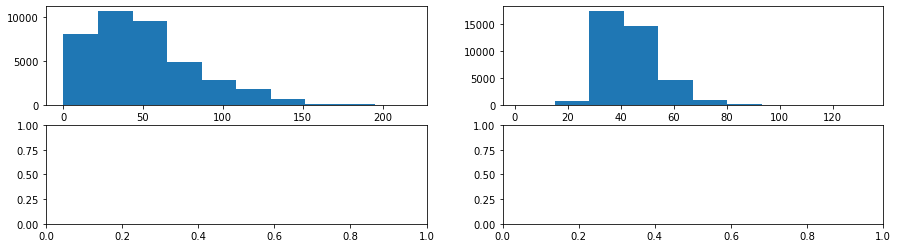

In [555]:
# plot elevation vs. snow depth and fsca (mean)
terrain_hist, axs = plt.subplots(2, 2, figsize =(15,4));
axs[0,0].hist(acc_df['swe_160326']); axs[0,0].set_xlabel('SWE 03/26/2016 (cm)')
axs[0,1].hist(acc_df['swe_080210']); axs[0,1].set_xlabel('SWE 02/10/2008 (cm)')
#axs[1,0].hist(acc_df['delta_acc_ASO']); axs[1,0].set_xlabel('delta_SWE 03/26/2016 (cm)')
#axs[1,1].hist(acc_df['delta_acc_NCALM']); axs[1,1].set_xlabel('delta_SWE 02/10/2008 (cm)')
#terrain_hist.savefig('lidar_processing/python_scripts/snow_departure_project/figures/terrain_variable_histogram.png')

In [249]:
# import matplotlib.ticker as mticker
# SWE_nness_elevBins_scatter, axes = plt.subplots(2,3,figsize=(25, 15), sharey=False, sharex=False) # create a figure axis
# #nness_deltaFSCA_group_box.suptitle('orthness vs. Change in fSCA') # add title to entire figure
# #palette_arr = ['darkorange','lightyellow','lightblue','royalblue']
# for i in range(3):
#     sns.scatterplot(ax=axes[0,i], y = (acc_df['swe_160326'][acc_df['elev_bins'] == elev_bins_arr_sort[i]]), x = (acc_df['nness'][acc_df['elev_bins'] == elev_bins_arr_sort[i]]))
#     axes[0,i].set(xticklabels = [],title = ('Elevation = ' + str(elev_bins_arr_sort[i])), xlabel = '',ylabel = 'SWE (cm) 03/26/2016')

#     sns.scatterplot(ax=axes[1,i], y = (acc_df['swe_160326'][acc_df['elev_bins'] == elev_bins_arr_sort[i+3]]), x = (acc_df['nness'][acc_df['elev_bins'] == elev_bins_arr_sort[i+3]]))
#     axes[1,i].set(title = ('Elevation = ' + str(elev_bins_arr_sort[i+3])), xlabel = 'Northness',ylabel = 'SWE (cm) 03/26/2016')
#     #axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(),rotation = 30, size = 10)
#     # ticks_loc = axes[1,i].get_xticks().tolist()
#     # axes[1,i].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#     # axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(),rotation = 30, size = 10)
# SWE_nness_elevBins_scatter.savefig('SCB/stats/figures/SWE_nness_elevBins_scatter.png')

In [354]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'nness_bins', 'elev_bins',
       'fVeg_bins'],
      dtype='object')

<AxesSubplot:xlabel='fVeg', ylabel='swe_160326'>

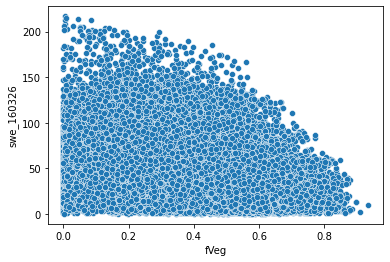

In [355]:
sns.scatterplot(data=acc_df, x="fVeg", y="swe_160326")

<AxesSubplot:xlabel='fVeg', ylabel='delta_acc_tall_ASO'>

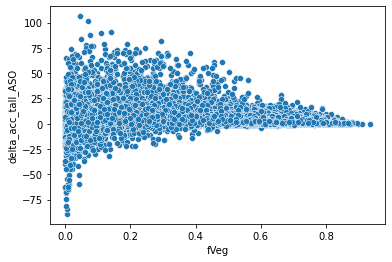

In [380]:
sns.scatterplot(data=acc_df, x="fVeg", y="delta_acc_tall_ASO")

In [394]:
abl_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'abl_MarApr', 'abl_MarMay',
       'abl_AprMay', 'delta_abl_MarApr', 'delta_abl_MarMay',
       'delta_abl_AprMay', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

<AxesSubplot:xlabel='elev', ylabel='abl_MarApr'>

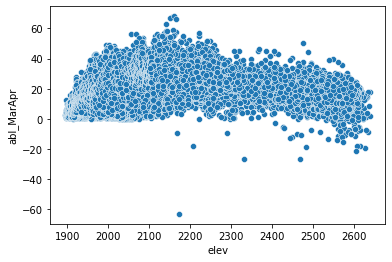

In [478]:
sns.scatterplot(data=abl_df, x="elev", y="abl_MarApr")

In [55]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'clump', 'swe_160326',
       'swe_080210', 'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM', 'nness_bins', 'elev_bins', 'fVeg_bins',
       'DNC_bins', 'clump_bins'],
      dtype='object')

Text(0.5, 0, 'Elevation')

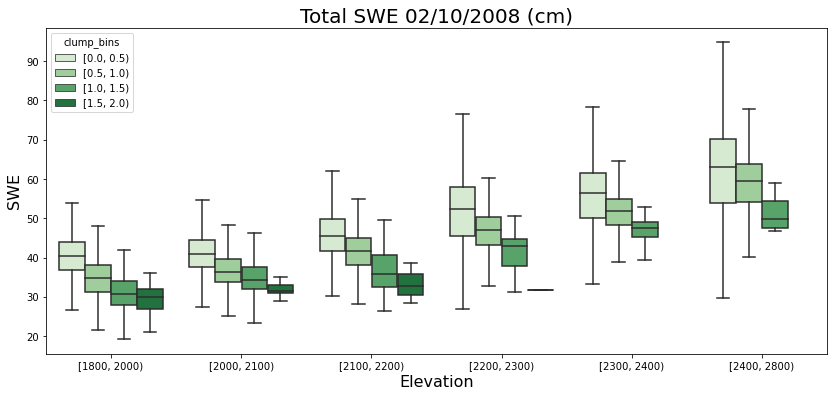

In [58]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_080210",showfliers = False, hue = 'clump_bins', palette="Greens")#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Total SWE 02/10/2008 (cm)', fontsize = 20)
axes.set_ylabel('SWE', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)


Text(0.5, 0, 'Elevation')

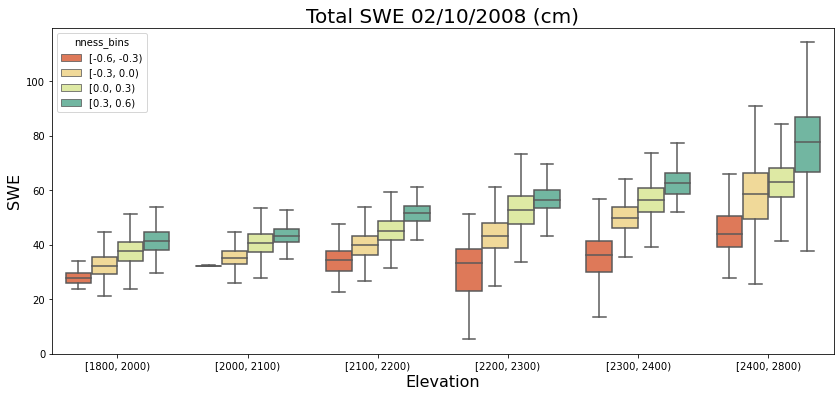

In [30]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_080210",showfliers = False, hue = 'nness_bins', palette="Spectral")#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Total SWE 02/10/2008 (cm)', fontsize = 20)
axes.set_ylabel('SWE', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)


In [75]:
acc_df['fVeg_avg'] = round(acc_df.fVeg,4)

In [76]:
fVeg_avg_df = acc_df.groupby('fVeg_avg').mean()

In [96]:
fVeg_avg_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'clump', 'swe_160326',
       'swe_080210', 'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM'],
      dtype='object')

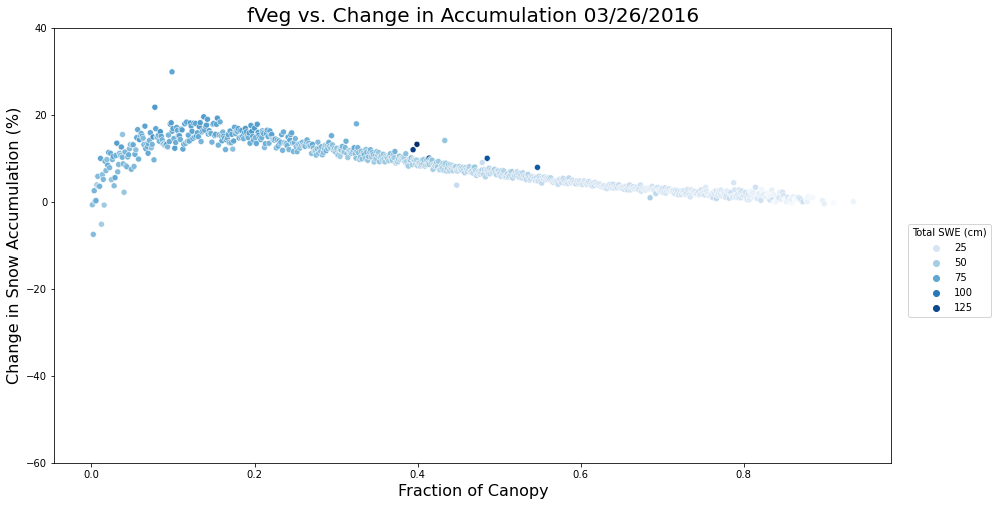

In [97]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=fVeg_avg_df, x='fVeg', y="delta_acc_tall_ASO", hue='swe_160326',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

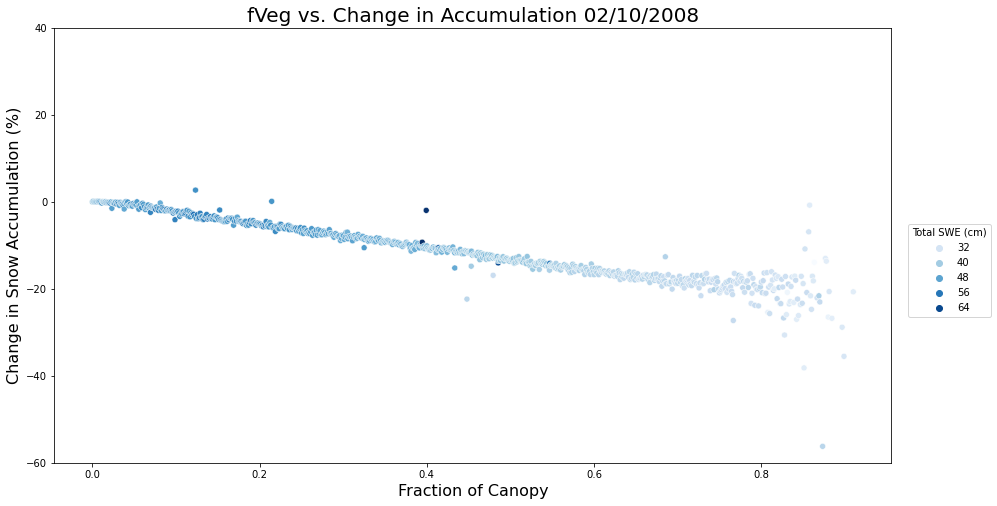

In [77]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=fVeg_avg_df, x='fVeg', y="delta_acc_NCALM", hue='swe_080210',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 02/10/2008', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

Text(0, 0.5, 'Total SWE (cm)')

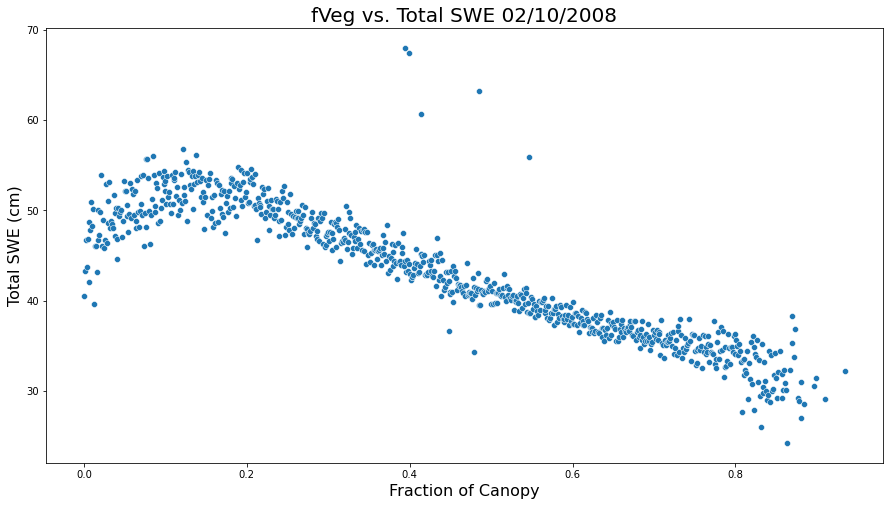

In [91]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=fVeg_avg_df, x='fVeg', y="swe_080210", palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Total SWE 02/10/2008', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Total SWE (cm)', fontsize = 16)
#axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

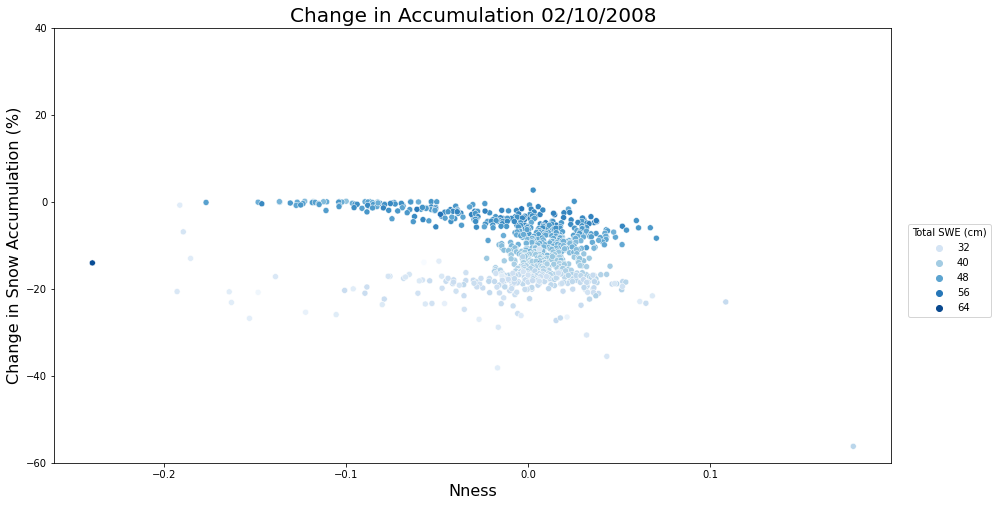

In [89]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=fVeg_avg_df, x='nness', y="delta_acc_NCALM", hue='swe_080210',palette='Blues') #, hue = 'nness_bins'
axes.set_title('Change in Accumulation 02/10/2008', fontsize = 20)
axes.set_xlabel('Nness', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

Text(0, 0.5, 'Total SWE (cm)')

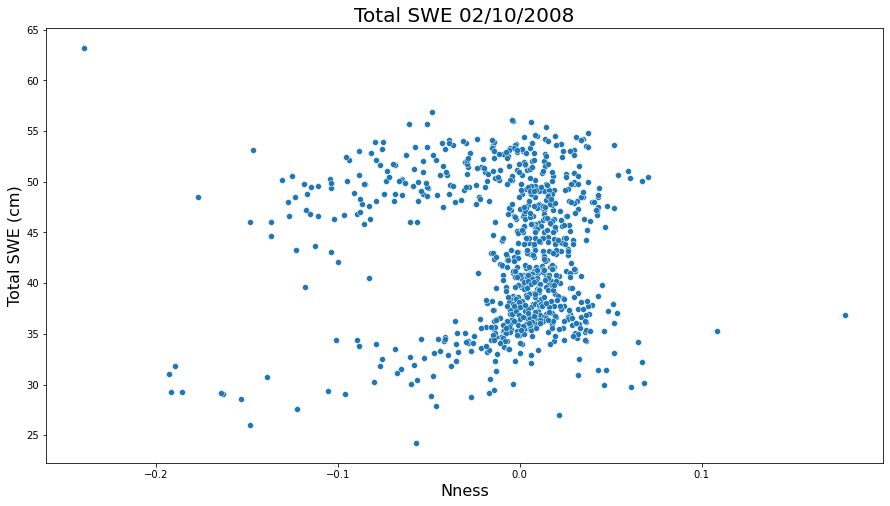

In [93]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=fVeg_avg_df, x='nness', y="swe_080210",palette='Blues') #, hue = 'nness_bins'
axes.set_title('Total SWE 02/10/2008', fontsize = 20)
axes.set_xlabel('Nness', fontsize = 16)
axes.set_ylabel('Total SWE (cm)', fontsize = 16)
#axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

# Final Plots

In [385]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

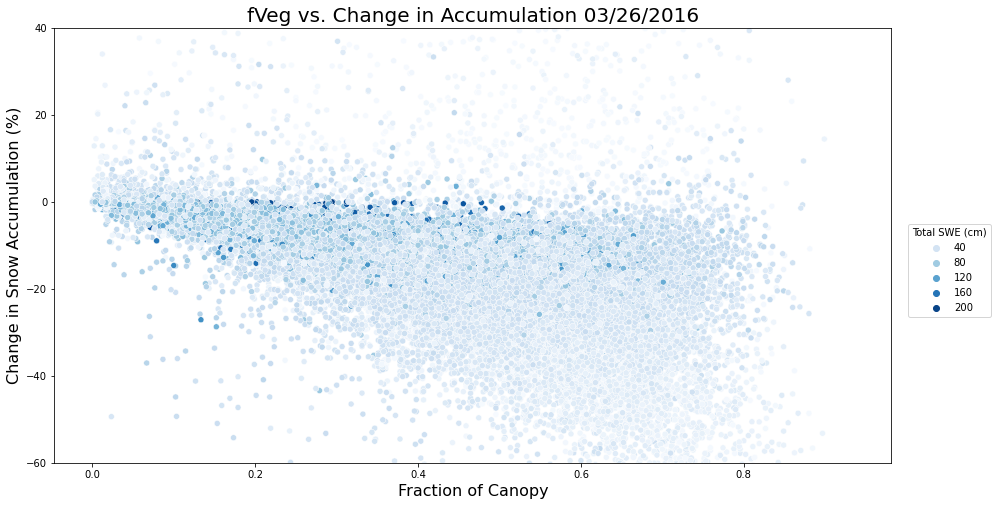

In [117]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=acc_df, x='fVeg', y="delta_acc_ASO", hue='swe_160326',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ASO_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

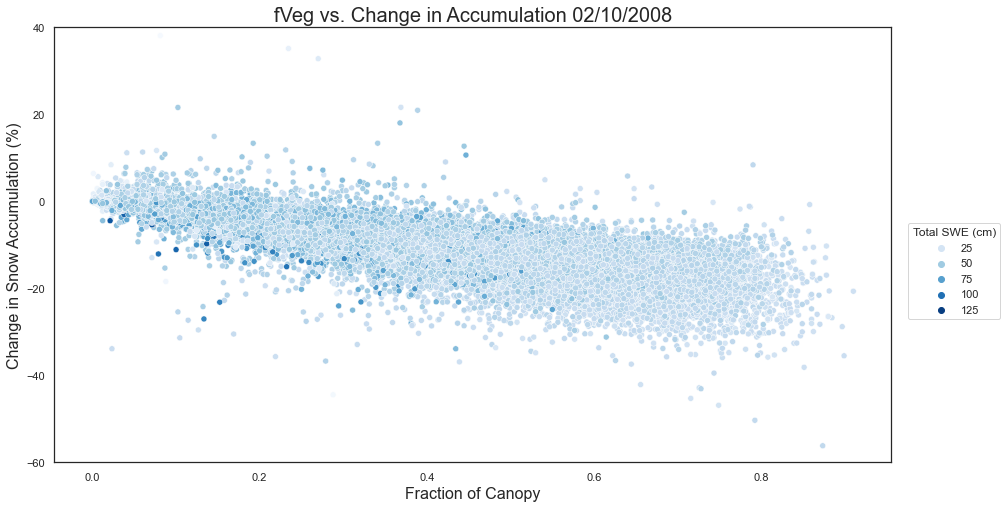

In [216]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=acc_df, x='fVeg', y="delta_acc_NCALM", hue='swe_080210',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 02/10/2008', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

## Ablation

In [152]:
abl_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_160417',
       'swe_160518', 'abl_MarApr', 'abl_MarMay', 'abl_AprMay',
       'abl_MarApr_open', 'abl_MarMay_open', 'abl_AprMay_open',
       'delta_abl_MarApr', 'delta_abl_MarMay', 'delta_abl_AprMay',
       'nness_bins', 'elev_bins', 'fVeg_bins', 'diff_abl_MarApr_mmd',
       'diff_abl_AprMay_mmd', 'diff_abl_MarMay_mmd', 'abl_MarApr_bins',
       'abl_MarMay_bins', 'abl_AprMay_bins'],
      dtype='object')

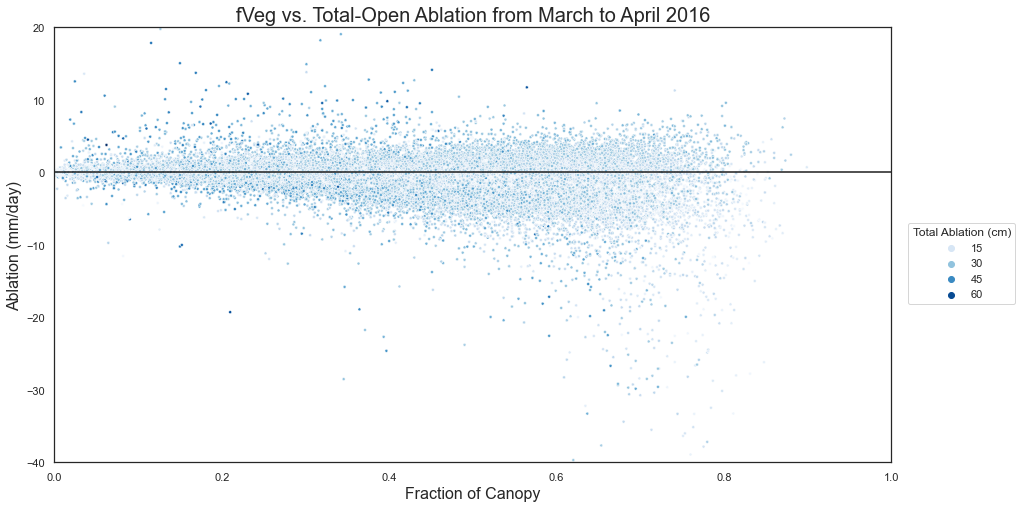

In [241]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="diff_abl_MarApr_mmd" ,hue = 'abl_MarApr',marker = '.', palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Total-Open Ablation from March to April 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Ablation (mm/day)', fontsize = 16)
axes.set(ylim=(-40, 20),xlim=(0,1))
axes.axhline(0, color='k')

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_MarMay_scatter.png',transparent=True,bbox_inches='tight')

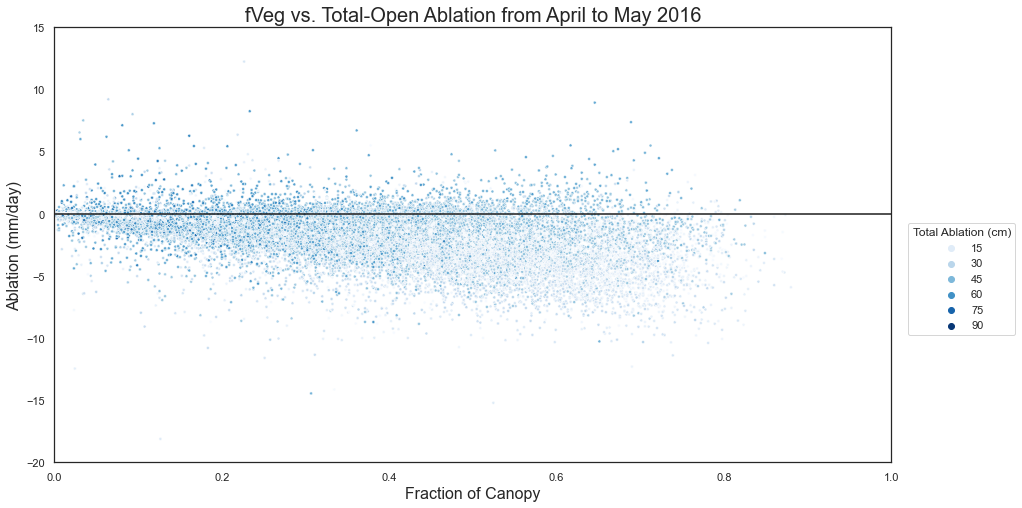

In [244]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="diff_abl_AprMay_mmd" ,hue ='abl_AprMay',palette="Blues", marker = '.') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Total-Open Ablation from April to May 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Ablation (mm/day)', fontsize = 16)
axes.set(ylim=(-20, 15),xlim=(0,1))
axes.axhline(0, color='k')


#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_MarMay_scatter.png',transparent=True,bbox_inches='tight')

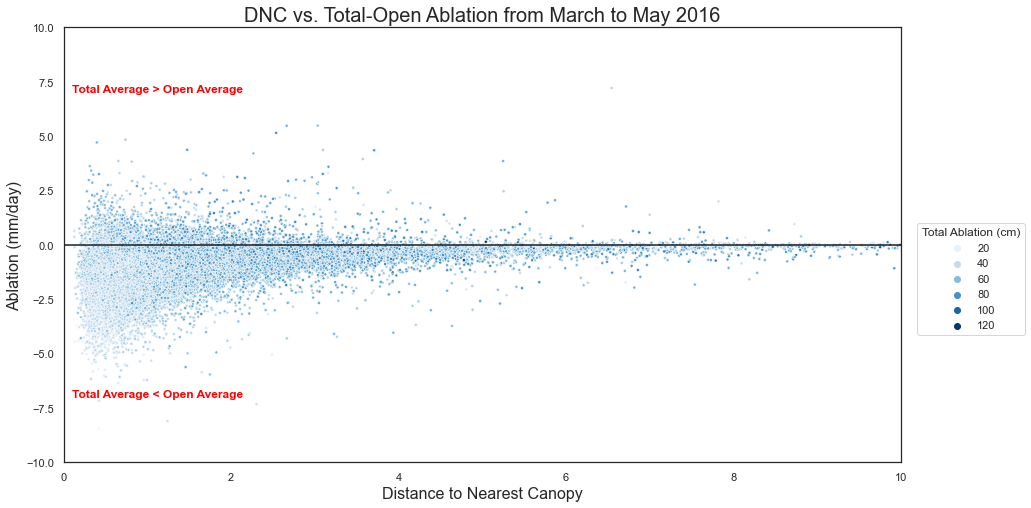

In [250]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='DNC', y="diff_abl_MarMay_mmd" ,marker = '.', hue='abl_MarMay', palette='Blues') #, hue = 'nness_bins'
axes.set_title('DNC vs. Total-Open Ablation from March to May 2016', fontsize = 20)
axes.set_xlabel('Distance to Nearest Canopy', fontsize = 16)
axes.set_ylabel('Ablation (mm/day)', fontsize = 16)
axes.axhline(0, color='k')
axes.set(ylim=(-10, 10),xlim=(0,10))
plt.text(0.1, 7, "Total Average > Open Average", horizontalalignment='left', size='medium', color='red', weight='semibold')
plt.text(0.1, -7, "Total Average < Open Average", horizontalalignment='left', size='medium', color='red', weight='semibold')

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_MarMay_scatter.png',transparent=True,bbox_inches='tight')

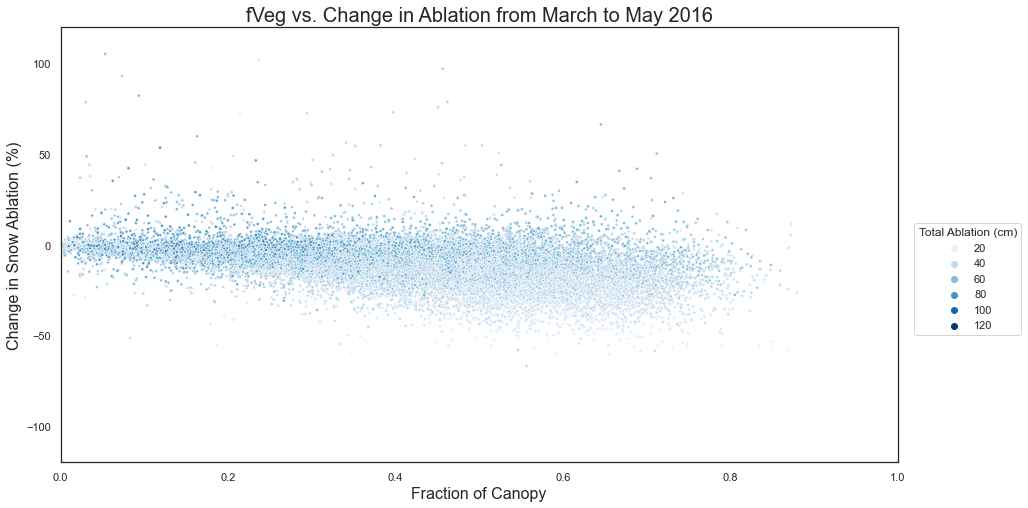

In [133]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_MarMay", hue = 'abl_MarMay', palette='Blues',marker = '.') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Total-Open Ablation from March to May 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
axes.set(ylim=(-120, 120),xlim=(0,1))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_MarMay_scatter.png',transparent=True,bbox_inches='tight')

In [94]:
abl_AprMay_bins_set

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

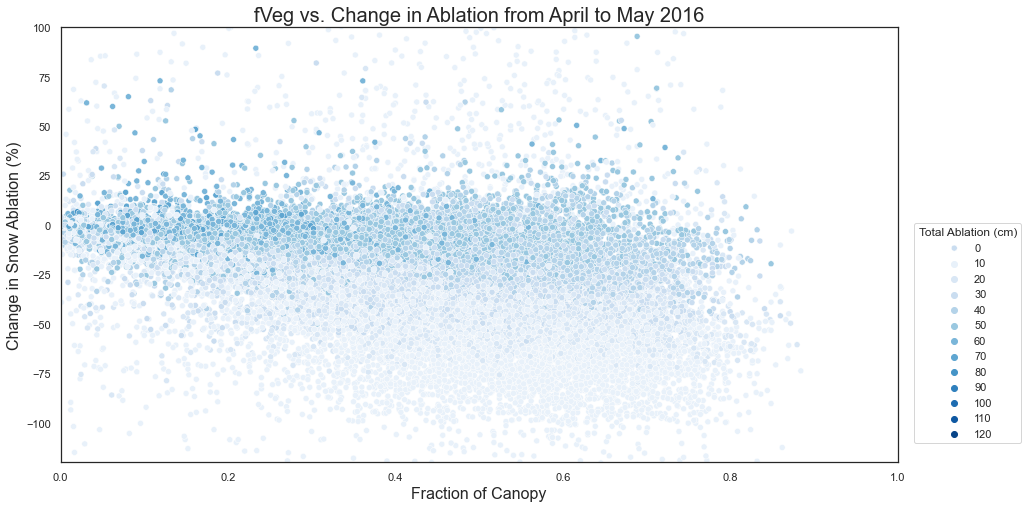

In [100]:
#sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_AprMay", hue = 'abl_AprMay_bins', palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Ablation from April to May 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
axes.set(ylim=(-120, 100),xlim=(0,1))
sns.set_style("white")

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120'],bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_AprMay_scatter.png',transparent=True,bbox_inches='tight')

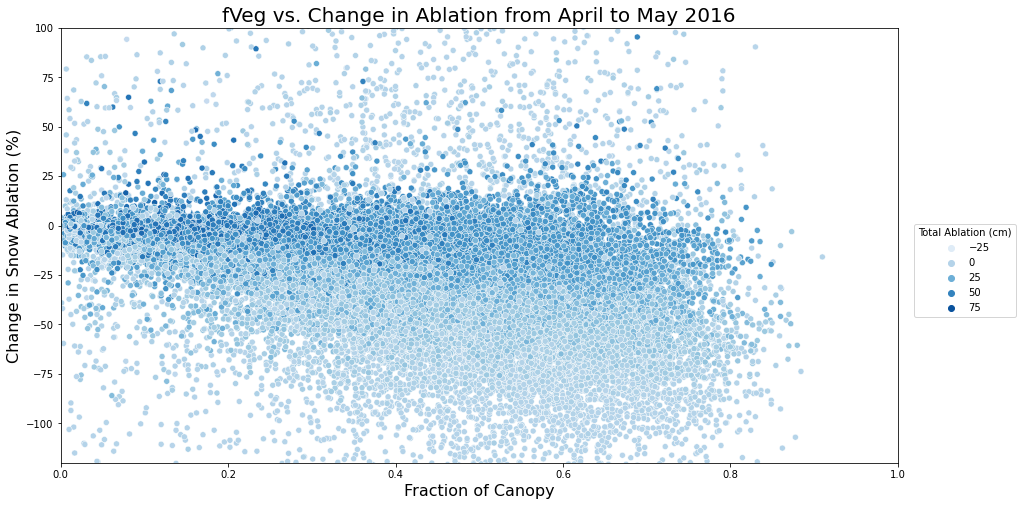

In [576]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_AprMay", hue = 'abl_AprMay', palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Ablation from April to May 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
axes.set(ylim=(-120, 100),xlim=(0,1))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_AprMay_scatter.png',transparent=True,bbox_inches='tight')

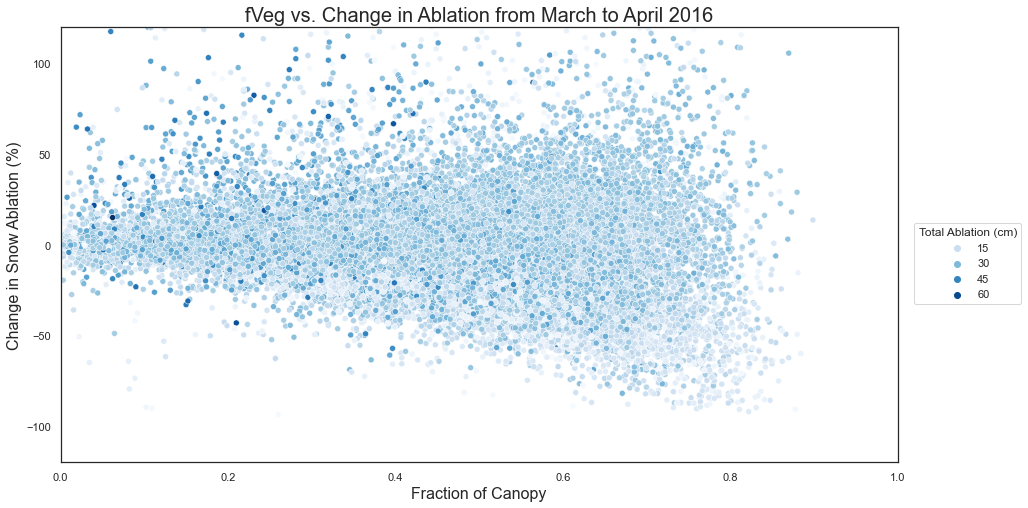

In [107]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_MarApr", hue = 'abl_MarApr', palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Ablation from March to April 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
axes.set(ylim=(-120, 120),xlim=(0,1))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

#plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_MarApr_scatter.png',transparent=True,bbox_inches='tight')

### Box

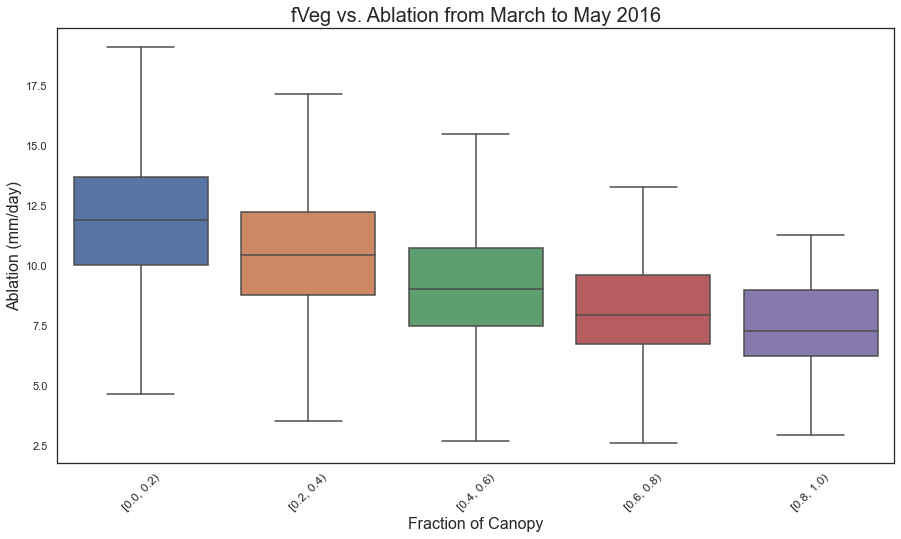

In [142]:
plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=abl_df, x='fVeg_bins', y="abl_MarMay_mmd" ,showfliers = False) #, hue = 'nness_bins'
axes.set_title('fVeg vs. Ablation from March to May 2016', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Ablation (mm/day)', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);


## Terrain

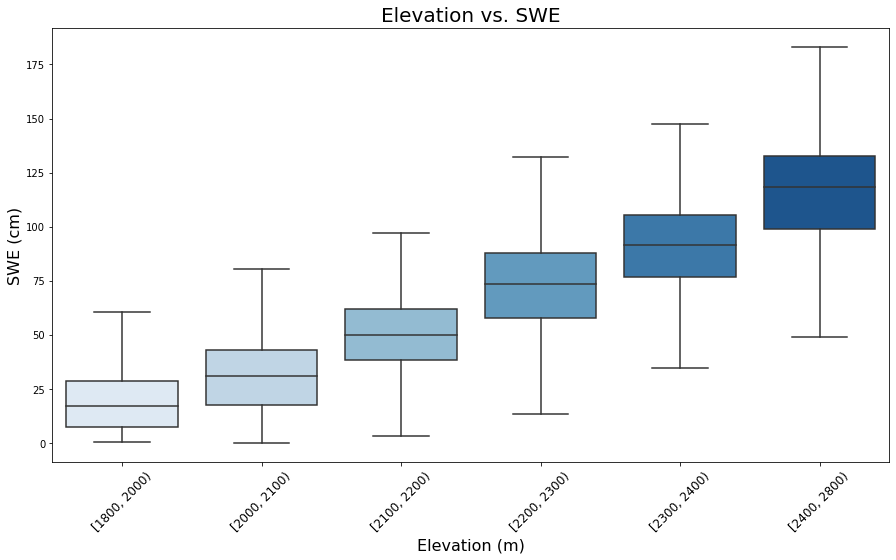

In [163]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_0326",showfliers = False,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Elevation vs. SWE', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

elev_SWE_box.savefig('SCB/stats/figures/elev_SWE_0326_box.png',transparent=True,bbox_inches='tight')

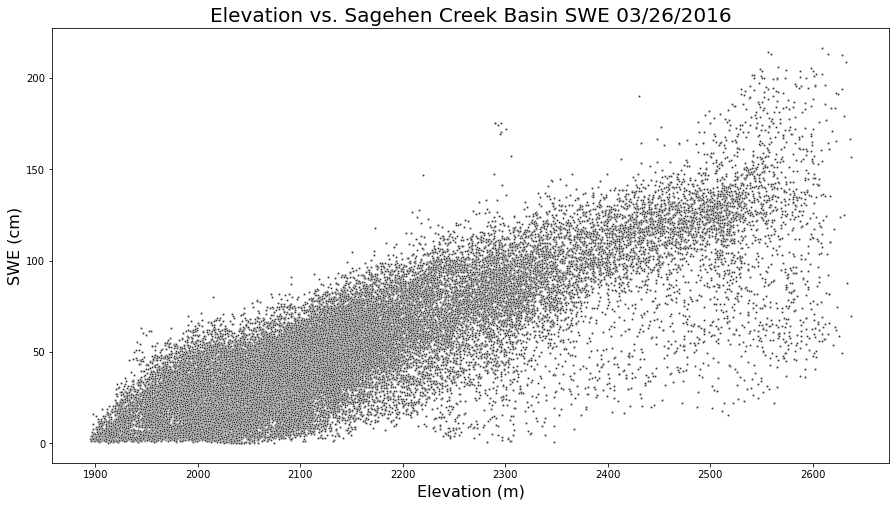

In [188]:
elev_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(data=acc_df, x="elev", y="swe_0326", s=20, color=".2", marker=".")
axes.set_title('Elevation vs. Sagehen Creek Basin SWE 03/26/2016', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 16)
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

elev_SWE_scatter.savefig('SCB/stats/figures/elev_SWE_0326_scatter.png',transparent=True,bbox_inches='tight')

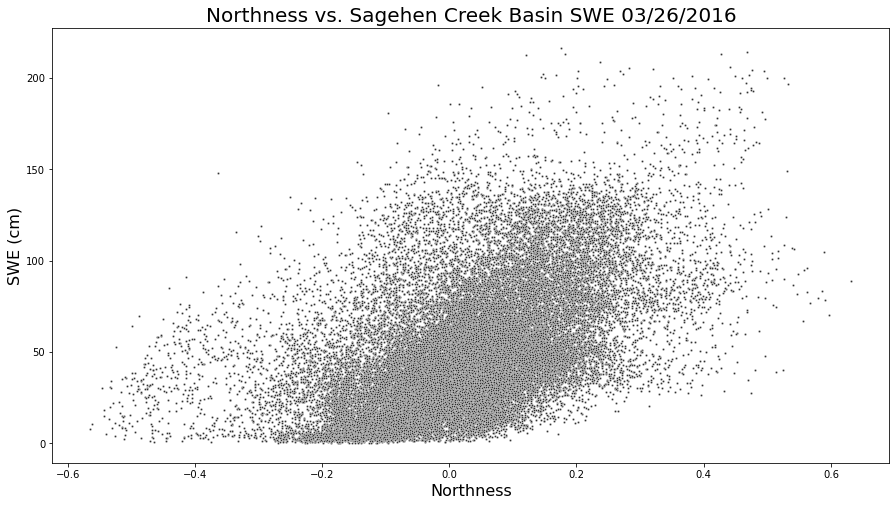

In [190]:
nness_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(data=acc_df, x="nness", y="swe_0326", s=20, color=".2", marker=".")
axes.set_title('Northness vs. Sagehen Creek Basin SWE 03/26/2016', fontsize = 20)
axes.set_xlabel('Northness', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 16)
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

nness_SWE_scatter.savefig('SCB/stats/figures/nness_SWE_0326_scatter.png',transparent=True,bbox_inches='tight')


In [360]:
elev_bins_arr = acc_df['elev_bins'].unique()
elev_bins_arr_sort = [elev_bins_arr.categories[0],elev_bins_arr.categories[1], elev_bins_arr.categories[2],elev_bins_arr.categories[3],elev_bins_arr.categories[4],elev_bins_arr.categories[5]] # create a new list with sorted values

In [362]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'nness_bins', 'elev_bins',
       'fVeg_bins'],
      dtype='object')

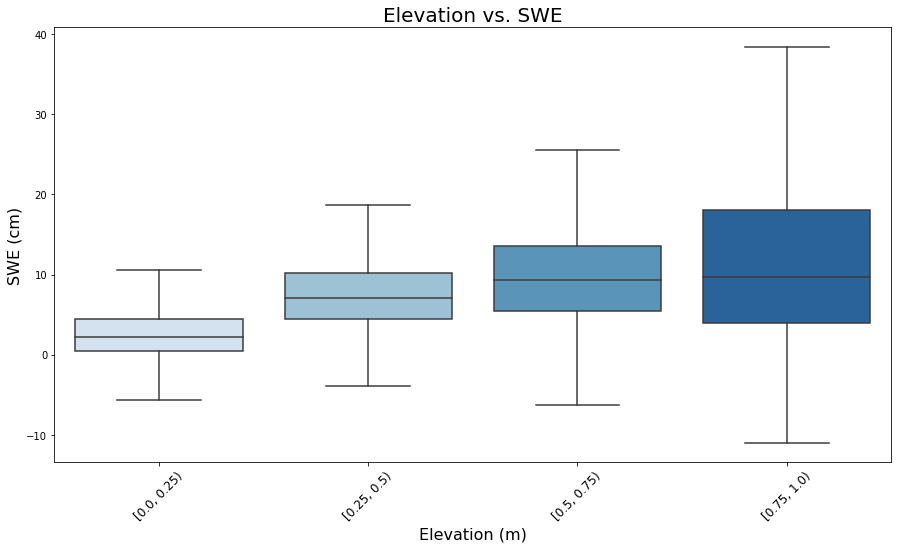

In [364]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=acc_df, x='fVeg_bins', y="delta_acc_ASO",showfliers = False,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Elevation vs. SWE', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

elev_SWE_box.savefig('SCB/stats/figures/elev_SWE_0326_box.png',transparent=True,bbox_inches='tight')

In [483]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

In [510]:
acc_df['elev_rnd'] = (round(acc_df.elev/100))*100

In [ ]:
elev_SWE_line, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.lineplot(x=acc_df['elev_rnd'],y=acc_df['swe_080210'], hue=acc_df["nness_bins"],style =acc_df["fVeg_bins"],  linewidth=2.5,markers=True)
axes.set_title('Elevation vs. SWE 02/10/2008', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0);

#elev_SWE_line.savefig('SCB/stats/figures/elev_SWE_line_08_huenness.png',transparent=True,bbox_inches='tight')

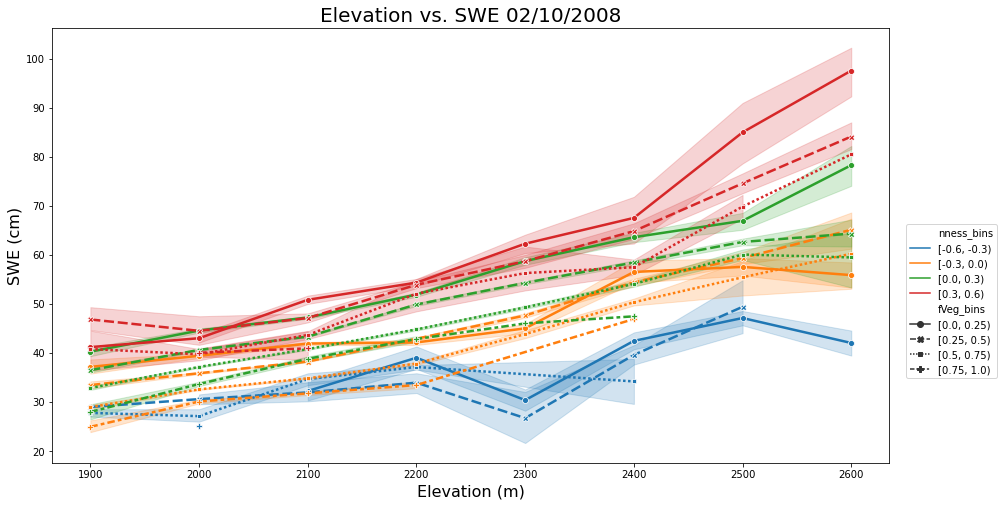

In [538]:


elev_SWE_line, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.lineplot(x=acc_df['elev_rnd'],y=acc_df['swe_080210'], hue=acc_df["nness_bins"],style =acc_df["fVeg_bins"],  linewidth=2.5,markers=True)
axes.set_title('Elevation vs. SWE 02/10/2008', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0);

#elev_SWE_line.savefig('SCB/stats/figures/elev_SWE_line_08_huenness.png',transparent=True,bbox_inches='tight')

# Regressions

In [262]:
# with sklearn, run single variable regression
# a downside of this approach is that the input dataframe contains unnecessary data. For now, that's okay
# input: dataframe - pandas dataframe with ind and dep variables
# input: var1 & var2 - independent and dependent variable names (str)
# output: regr_model - sklearn LinearRegreassion()
# output: regression_df - dataframe with residual value
def sing_var_regress(dataframe, var1, var2):
    # establish ind. and dep. variables
    regression_df = dataframe[[var1,var2]].dropna(subset=[var1,var2])
    ind_df = regression_df[[var1]]
    dep_df = regression_df[[var2]]
    # run regression model 
    regr_model = linear_model.LinearRegression()
    regr_model.fit(ind_df,dep_df)
    # calculate residuals
    residual_var = dep_df.values - regr_model.predict(ind_df)
    predicted_var = regr_model.predict(ind_df)
    regression_df.insert(len(regression_df.columns), "residual_var", residual_var, True)
    regression_df.insert(len(regression_df.columns), "predicted_var", predicted_var, True)

    return regr_model, regression_df

In [391]:
acc_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'delta_acc_tall_ASO',
       'delta_acc_tall_NCALM', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

In [452]:
abl_df.columns

Index(['elev', 'nness', 'slope', 'fVeg', 'DNC', 'abl_MarApr', 'abl_MarMay',
       'abl_AprMay', 'delta_abl_MarApr', 'delta_abl_MarMay',
       'delta_abl_AprMay', 'nness_bins', 'elev_bins', 'fVeg_bins'],
      dtype='object')

In [473]:
regr_model, regression_df = sing_var_regress(abl_df, 'elev', 'abl_AprMay')
print('r-squared: \n',r2_score(regression_df['abl_AprMay'],regr_model.predict(regression_df[['elev']])))

r-squared: 
 0.4122890788259671


In [319]:
#sns.scatterplot(data=regression_df, x="elev", y="residual_var")

In [78]:
acc_df

elev     nness      slope      fVeg       DNC     clump  \
0      2193.880267       NaN   5.606432  0.241111  3.782615  0.342742   
1      2191.230491       NaN   5.746143  0.522222  0.630054  0.642668   
2      2189.194959       NaN   4.161548  0.451111  0.903932  0.597282   
3      2187.957804       NaN   3.718212  0.516667  0.744819  0.704089   
4      2187.046608       NaN   3.867825  0.680000  0.359035  0.906929   
...            ...       ...        ...       ...       ...       ...   
71781  1947.159726  0.090204   7.733279  0.474444  0.762612  0.634546   
71782  1949.612040  0.112662   8.213658  0.351111  1.496196  0.469677   
71783  1948.525441  0.126658   9.085349  0.606667  0.555566  0.921868   
71784  1945.558060  0.117534  10.530896  0.738889  0.363351  1.250377   
71785  1940.998999  0.101927  12.241092  0.794444  0.241652  1.440223   

       swe_160326  swe_080210  delta_acc_ASO  delta_acc_NCALM  \
0             NaN         NaN            NaN              NaN   
1             NaN         NaN            NaN              NaN   
2             NaN         NaN            NaN              NaN   
3             NaN         NaN            NaN              NaN   
4             NaN         NaN            NaN              NaN   
...           ...         ...            ...              ...   
71781         NaN         NaN            NaN              NaN   
71782         NaN         NaN            NaN              NaN   
71783         NaN         NaN            NaN              NaN   
71784         NaN         NaN            NaN              NaN   
71785         NaN         NaN            NaN              NaN   

       delta_acc_tall_ASO  delta_acc_tall_NCALM  nness_bins     elev_bins  \
0                     NaN                   NaN         NaN  [2100, 2200)   
1                     NaN                   NaN         NaN  [2100, 2200)   
2                     NaN                   NaN         NaN  [2100, 2200)   
3                     NaN                   NaN         NaN  [2100, 2200)   
4                     NaN                   NaN         NaN  [2100, 2200)   
...                   ...                   ...         ...           ...   
71781                 NaN                   NaN  [0.0, 0.3)  [1800, 2000)   
71782                 NaN                   NaN  [0.0, 0.3)  [1800, 2000)   
71783                 NaN                   NaN  [0.0, 0.3)  [1800, 2000)   
71784                 NaN                   NaN  [0.0, 0.3)  [1800, 2000)   
71785                 NaN                   NaN  [0.0, 0.3)  [1800, 2000)   

         fVeg_bins DNC_bins  clump_bins  fVeg_avg  
0      [0.0, 0.25)   [0, 5)  [0.0, 0.5)    0.2411  
1      [0.5, 0.75)   [0, 5)  [0.5, 1.0)    0.5222  
2      [0.25, 0.5)   [0, 5)  [0.5, 1.0)    0.4511  
3      [0.5, 0.75)   [0, 5)  [0.5, 1.0)    0.5167  
4      [0.5, 0.75)   [0, 5)  [0.5, 1.0)    0.6800  
...            ...      ...         ...       ...  
71781  [0.25, 0.5)   [0, 5)  [0.5, 1.0)    0.4744  
71782  [0.25, 0.5)   [0, 5)  [0.0, 0.5)    0.3511  
71783  [0.5, 0.75)   [0, 5)  [0.5, 1.0)    0.6067  
71784  [0.5, 0.75)   [0, 5)  [1.0, 1.5)    0.7389  
71785  [0.75, 1.0)   [0, 5)  [1.0, 1.5)    0.7944  

[71786 rows x 18 columns]

In [85]:
regression_df.columns

Index(['elev', 'nness', 'fVeg', 'DNC', 'clump', 'swe_080210',
       'delta_acc_NCALM'],
      dtype='object')

In [87]:
# using statsmodel
regression_df = acc_df[["elev","nness","fVeg","DNC","clump", "swe_080210","delta_acc_NCALM"]].dropna(subset=["elev","nness","fVeg","DNC","clump", "swe_080210","delta_acc_NCALM"])
Y = regression_df['delta_acc_NCALM']
X = regression_df[["elev","nness","fVeg","DNC","clump"]]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:        delta_acc_NCALM   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                 1.285e+04
Date:                Fri, 06 May 2022   Prob (F-statistic):               0.00
Time:                        07:55:57   Log-Likelihood:            -1.0878e+05
No. Observations:               38458   AIC:                         2.176e+05
Df Residuals:                   38452   BIC:                         2.176e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.4924      0.352    -26.971      0.0

# Varhola comp test w/ snowpalm

In [199]:
snowpalm_df

fVeg  delta_acc_2016
0  -95.0        8.049061
1  -94.0        8.017177
2  -93.0        7.985294
3  -92.0        7.953411
4  -91.0        7.921527
..   ...             ...
86  -9.0        5.307095
87  -8.0        5.275211
88  -7.0        5.243328
89  -6.0        5.211445
90  -5.0        5.179561

[91 rows x 2 columns]

In [124]:
# load into array
ASO_0326_open_arr = raster_to_array(ASO_0326_open, -9999)
ASO_0326_tall_arr = raster_to_array(ASO_0326_tall, -9999)
ASO_0326_all_arr = raster_to_array(ASO_0326_all, -9999)
ASO_delta_acc_arr = raster_to_array(ASO_delta_acc, -9999)
ASO_delta_acc_tall_arr = raster_to_array(ASO_delta_acc_tall, -9999)


In [194]:
test_df = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "slope": slope_arr,
    "fVeg": fVEG_arr,
    "ASO_0326_open":ASO_0326_open_arr,
    "ASO_0326_tall":ASO_0326_tall_arr,
    "ASO_0326_all":ASO_0326_all_arr,
    "ASO_delta_acc":ASO_delta_acc_arr,
    "ASO_delta_acc_tall":ASO_delta_acc_tall_arr
})
elev_bins_set = ([1800,2000,2100,2200,2300,2400,2800])
nness_bins_set = ([-0.6,-0.3,0,0.3,0.6])
fVEG_bins_set = ([0,0.25,0.5, 0.75, 1.0])
DNC_bins_set = ([0,5,10,15,20])
clump_bins_set = ([0, 0.5, 1, 1.5, 2])


test_df['nness_bins'] = pd.cut(test_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
test_df['elev_bins'] = pd.cut(test_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
test_df['fVeg_bins'] = pd.cut(test_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
elev_bins_arr = acc_df['elev_bins'].unique()
nness_bins_arr = acc_df['nness_bins'].unique()

In [195]:
test_df['tall_ref'] = np.nan
for i in range(6):
    for j in range(5):
        tall_all = test_df.ASO_0326_tall[(test_df['elev_bins']==elev_bins_arr[i]) & (test_df['nness_bins']==nness_bins_arr[j])]
        tall_avg = np.nanmean(tall_all)
        test_df.tall_ref[(test_df['elev_bins']==elev_bins_arr[i]) & (test_df['nness_bins']==nness_bins_arr[j])] = tall_avg

C:\Users\cpiske\AppData\Local\Temp/ipykernel_42912/3604298735.py:5: RuntimeWarning: Mean of empty slice
  tall_avg = np.nanmean(tall_all)
C:\Users\cpiske\AppData\Local\Temp/ipykernel_42912/3604298735.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.tall_ref[(test_df['elev_bins']==elev_bins_arr[i]) & (test_df['nness_bins']==nness_bins_arr[j])] = tall_avg


In [197]:
test_df['delta_acc_tallRef'] = (test_df['ASO_0326_all'] -  test_df['tall_ref'])/test_df['tall_ref']*100
test_df['fVeg'] = -(1-test_df['fVeg'])*100

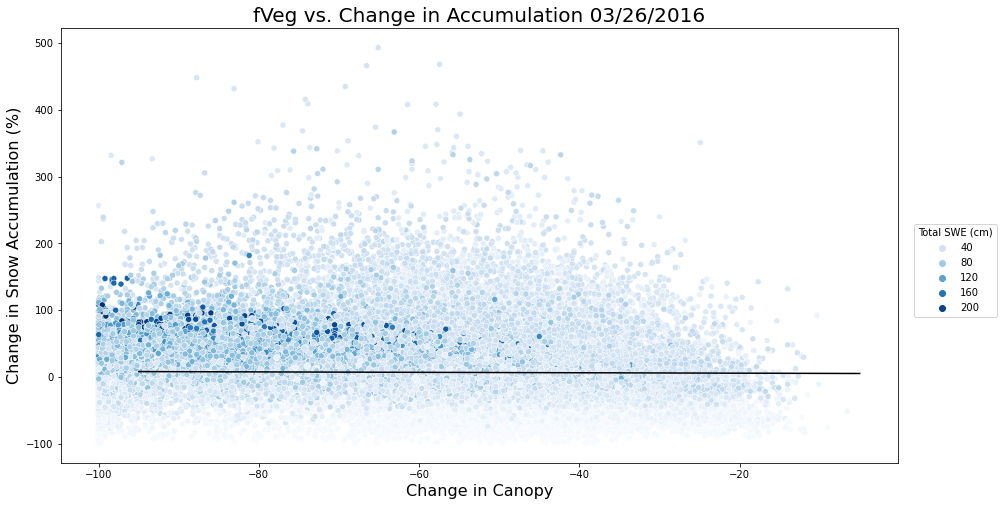

In [209]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=test_df, x='fVeg', y="delta_acc_tallRef", hue='ASO_0326_all',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
axes.set_xlabel('Change in Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
#axes.set(ylim=(-60, 40))
sns.lineplot(ax=axes, data=snowpalm_df, x='fVeg', y="delta_acc_2016", color='k') #, hue = 'nness_bins'

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ASO_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')

In [215]:
test_df['fVeg_avg'] = round(test_df.fVeg,2)

In [216]:
test_avg_df = test_df.groupby('fVeg_avg').mean()

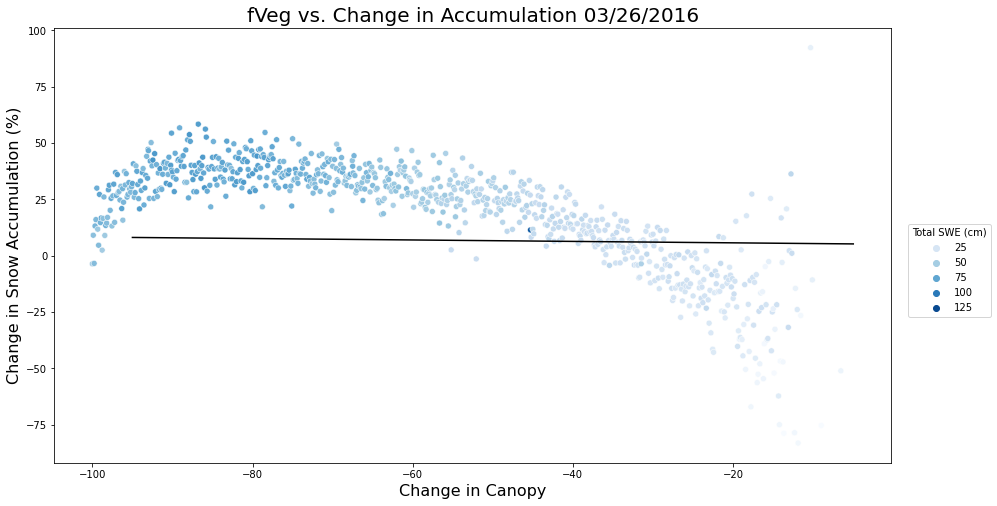

In [217]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=test_avg_df, x='fVeg', y="delta_acc_tallRef", hue='ASO_0326_all',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
axes.set_xlabel('Change in Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
#axes.set(ylim=(-60, 40))
sns.lineplot(ax=axes, data=snowpalm_df, x='fVeg', y="delta_acc_2016", color='k') #, hue = 'nness_bins'

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ASO_delta_SWE_scatter.png',transparent=True,bbox_inches='tight')